# Rotary Positional Embeddings (RoPE)

To understand RoPE, you must fundamentally change how you view "position."

- **Old View (Absolute/Learnable):** Position is a signal we add to the data.
- **New View (RoPE):** Position is an orientation in space.

## Core Idea of RoPE (one sentence)

**RoPE rotates token embeddings in a position-dependent way so that attention naturally understands relative distance.**

## Why Rotation Works Better Than Addition

### Learnable Embeddings (old way)
```
embedding = word_vector + position_vector
```

**Problem:**
- Position info is mixed with meaning
- Hard to infer distance

### RoPE (new way)
```
embedding = ROTATE(word_vector, angle = position)
```

**Key advantage:**
- Rotation preserves length
- Only changes direction
- Relative angle difference = relative position difference

## How Rotation is Done (simple math, no fear)

Each embedding is split into pairs:
```
[x1, x2], [x3, x4], [x5, x6], ...
```

Each pair acts like a **2D vector**.

### Rotation Formula:
```
[x', y'] = [ x*cosθ - y*sinθ ,
             x*sinθ + y*cosθ ]
```

**θ (theta) depends on:**
- Token position
- Embedding dimension

## The Math: Rotation Matrices

Imagine a 2D vector $(x_1, x_2)$. In the complex plane, this is $x_1 + i x_2$.

To rotate this vector by an angle $\theta$, we multiply it by $e^{i\theta}$.

### How RoPE Works

RoPE applies this to the high-dimensional embedding vector by **chopping it into chunks of 2**.

If $d_{model} = 512$, we treat it as **256 pairs** of coordinates.

### The Rotation Formula

For a token at position $m$, we rotate the pair $(x_1, x_2)$ by an angle $m \theta$:

$$\begin{pmatrix} x'_1 \\ x'_2 \end{pmatrix} = \begin{pmatrix} \cos(m\theta) & -\sin(m\theta) \\ \sin(m\theta) & \cos(m\theta) \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix}$$

### The Magic Property ✨

If you take the dot product of a **Query** rotated by $m\theta$ and a **Key** rotated by $n\theta$, the math simplifies beautifully:

$$\text{Score} = \text{OriginalScore} \times \cos((m - n)\theta)$$

**The absolute positions $m$ and $n$ disappear!** Only the relative distance $(m - n)$ remains.

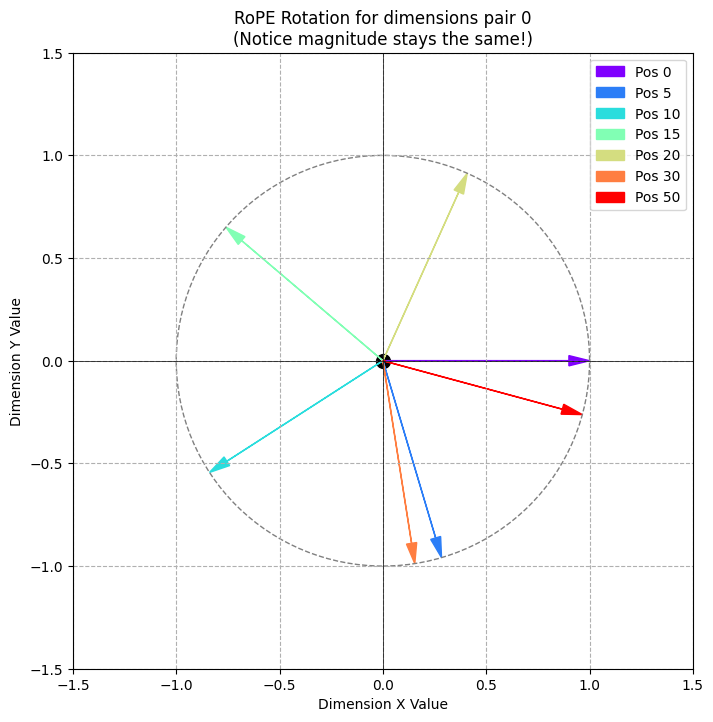

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- Configuration ---
d_model = 64          # Total dimensions
head_dim_pair = 0     # We are looking at the very first pair of dimensions (the fastest rotation)
base_vector = np.array([1.0, 0.0]) # Our starting vector (pointing right along X-axis)
positions_to_plot = [0, 5, 10, 15, 20, 30, 50]

# --- Helper Function: Calculate RoPE Rotation for 2D ---
def get_rotated_2d_vector(vector, position, d_model, pair_index):
    """
    Calculates the rotation for a single pair of dimensions at a given position.
    """
    # 1. Calculate the frequency angle (theta) for this specific pair
    # Formula: theta_i = 10000^(-2i/d)
    theta = 1.0 / (10000 ** ((2 * pair_index) / d_model))
    
    # 2. Calculate total rotation angle for this position
    angle_rad = position * theta
    
    # 3. Apply standard 2D rotation matrix:
    # [ x'] = [ cos(a) -sin(a) ] [ x ]
    # [ y'] = [ sin(a)  cos(a) ] [ y ]
    x, y = vector
    x_rot = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_rot = x * np.sin(angle_rad) + y * np.cos(angle_rad)
    
    return np.array([x_rot, y_rot])

# --- PLOTTING ---
plt.figure(figsize=(8, 8))
colors = cm.rainbow(np.linspace(0, 1, len(positions_to_plot)))

# Plot origin
plt.scatter(0, 0, color='black', s=100)

for i, pos in enumerate(positions_to_plot):
    # Rotate the base vector according to the position
    rotated_v = get_rotated_2d_vector(base_vector, pos, d_model, head_dim_pair)
    
    # Plot as an arrow
    plt.arrow(0, 0, rotated_v[0], rotated_v[1], 
              head_width=0.05, head_length=0.1, fc=colors[i], ec=colors[i], 
              length_includes_head=True, label=f"Pos {pos}")

# Formatting
draw_circle = plt.Circle((0, 0), 1.0,fill=False, color='gray', linestyle='--')
plt.gcf().gca().add_artist(draw_circle)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(True, linestyle='--')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)
plt.legend()
plt.title(f"RoPE Rotation for dimensions pair {head_dim_pair}\n(Notice magnitude stays the same!)")
plt.xlabel("Dimension X Value")
plt.ylabel("Dimension Y Value")
plt.show()

--- The Magic of Relative Attention ---
Scenario A: Q at pos 5, K at pos 10 (Dist 5). Score: 0.987593
Scenario B: Q at pos 105, K at pos 110 (Dist 5). Score: 0.987593

SUCCESS: The attention scores are identical despite absolute positions changing!


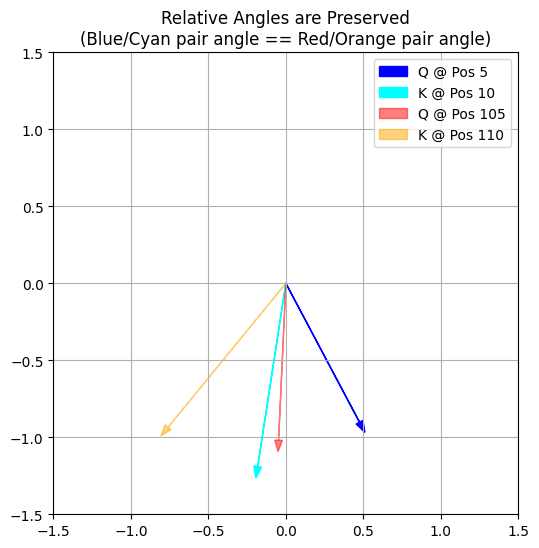

In [2]:
def get_dot_product_angle(v1, v2):
    """Calculates cosine similarity (dot product) between two vectors."""
    # Using numpy dot product
    dot_prod = np.dot(v1, v2)
    # We assume normalized vectors for simplicity in this visualization
    return dot_prod

# Let's define two arbitrary semantic vectors (Query and Key)
# Q wants to find K. They point in slightly different directions.
Q_base = np.array([1.0, 0.2]) 
K_base = np.array([0.8, 0.9])

# --- SCENARIO A: Start of the sentence ---
pos_Q_A = 5
pos_K_A = 10  # Distance is 5

# Apply RoPE to both based on their positions
Q_rotated_A = get_rotated_2d_vector(Q_base, pos_Q_A, d_model, head_dim_pair)
K_rotated_A = get_rotated_2d_vector(K_base, pos_K_A, d_model, head_dim_pair)

# Calculate Attention Score (Dot Product)
score_A = get_dot_product_angle(Q_rotated_A, K_rotated_A)


# --- SCENARIO B: Deep in the sentence ---
# We shift both positions by +100. The relative distance is STILL 5.
pos_Q_B = 105
pos_K_B = 110 

# Apply RoPE to both based on new positions
Q_rotated_B = get_rotated_2d_vector(Q_base, pos_Q_B, d_model, head_dim_pair)
K_rotated_B = get_rotated_2d_vector(K_base, pos_K_B, d_model, head_dim_pair)

# Calculate Attention Score (Dot Product)
score_B = get_dot_product_angle(Q_rotated_B, K_rotated_B)

# --- RESULTS ---
print("--- The Magic of Relative Attention ---")
print(f"Scenario A: Q at pos {pos_Q_A}, K at pos {pos_K_A} (Dist 5). Score: {score_A:.6f}")
print(f"Scenario B: Q at pos {pos_Q_B}, K at pos {pos_K_B} (Dist 5). Score: {score_B:.6f}")

np.testing.assert_almost_equal(score_A, score_B)
print("\nSUCCESS: The attention scores are identical despite absolute positions changing!")

# --- Visualizing the Scenario B vectors to show they really did rotate ---
plt.figure(figsize=(6,6))
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(True)
# Draw Scenario A pair
plt.arrow(0, 0, Q_rotated_A[0], Q_rotated_A[1], head_width=0.05, color='blue', label=f'Q @ Pos {pos_Q_A}')
plt.arrow(0, 0, K_rotated_A[0], K_rotated_A[1], head_width=0.05, color='cyan', label=f'K @ Pos {pos_K_A}')

# Draw Scenario B pair (translucent)
plt.arrow(0, 0, Q_rotated_B[0], Q_rotated_B[1], head_width=0.05, color='red', alpha=0.5, label=f'Q @ Pos {pos_Q_B}')
plt.arrow(0, 0, K_rotated_B[0], K_rotated_B[1], head_width=0.05, color='orange', alpha=0.5, label=f'K @ Pos {pos_K_B}')

plt.title("Relative Angles are Preserved\n(Blue/Cyan pair angle == Red/Orange pair angle)")
plt.legend()
plt.show()


--- Training with SINUSOIDAL ---
Step 0: Loss 4.3149
Step 100: Loss 2.4517
Step 200: Loss 2.2009
Step 300: Loss 2.0439
Step 400: Loss 1.9608
Step 500: Loss 1.8879
Step 600: Loss 1.7202
Step 700: Loss 1.7810
Step 800: Loss 1.7068
Step 900: Loss 1.6716

--- Training with LEARNABLE ---
Step 0: Loss 4.3453
Step 100: Loss 2.5003
Step 200: Loss 2.3111
Step 300: Loss 2.1717
Step 400: Loss 2.0186
Step 500: Loss 1.9100
Step 600: Loss 1.7753
Step 700: Loss 1.8762
Step 800: Loss 1.7617
Step 900: Loss 1.7605

--- Training with ROPE ---
Step 0: Loss 4.2464
Step 100: Loss 2.2071
Step 200: Loss 1.9551
Step 300: Loss 1.7551
Step 400: Loss 1.7298
Step 500: Loss 1.6719
Step 600: Loss 1.6331
Step 700: Loss 1.6764
Step 800: Loss 1.6173
Step 900: Loss 1.6008


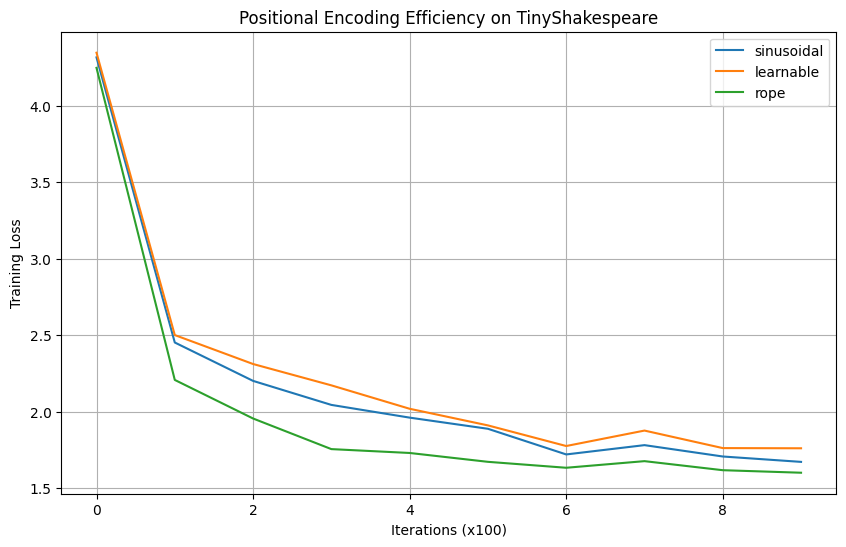

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# We use a small config to make it run fast in a notebook
class Config:
    block_size = 64      # Context length
    vocab_size = 65      # TinyShakespeare has ~65 unique chars
    n_layer = 4          # Number of transformer blocks
    n_head = 4           # Number of heads
    n_embd = 128         # Embedding dimension
    dropout = 0.1
    learning_rate = 1e-3
    max_iters = 1000     # Training steps
    eval_interval = 100
    batch_size = 32
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- COMPONENTS ---

class RoPE(nn.Module):
    """Rotary Positional Embeddings (The Modern Standard)"""
    def __init__(self, d_model, max_len=4096):
        super().__init__()
        self.d_model = d_model
        # Create rotation matrix
        inv_freq = 1.0 / (10000 ** (torch.arange(0, d_model, 2).float() / d_model))
        t = torch.arange(max_len).type_as(inv_freq)
        freqs = torch.outer(t, inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos())
        self.register_buffer("sin_cached", emb.sin())

    def forward(self, x):
        # x: [batch, seq_len, heads, head_dim]
        seq_len = x.shape[1]
        return self.cos_cached[:seq_len, :], self.sin_cached[:seq_len, :]

def rotate_half(x):
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

def apply_rope(x, cos, sin):
    # Ensure dimensions match for broadcasting
    # x: [B, T, H, D], cos/sin: [T, D] -> reshape to [1, T, 1, D]
    cos = cos.view(1, cos.shape[0], 1, cos.shape[1])
    sin = sin.view(1, sin.shape[0], 1, sin.shape[1])
    return (x * cos) + (rotate_half(x) * sin)

class CausalSelfAttention(nn.Module):
    def __init__(self, config, use_rope=False):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=False)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=False)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.use_rope = use_rope
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x, rope_components=None):
        B, T, C = x.size()
        # q, k, v shape: (B, T, n_head, head_dim)
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        q = q.view(B, T, self.n_head, C // self.n_head) # No transpose yet for RoPE convenience
        k = k.view(B, T, self.n_head, C // self.n_head)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # v is standard

        # --- CRITICAL: RoPE INJECTION POINT ---
        if self.use_rope and rope_components is not None:
            cos, sin = rope_components
            q = apply_rope(q, cos, sin)
            k = apply_rope(k, cos, sin)
        
        # Now transpose q, k to standard [B, H, T, D]
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)

        # Standard Attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        return self.c_proj(y)

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )
    def forward(self, x): return self.net(x)

class Block(nn.Module):
    def __init__(self, config, use_rope=False):
        super().__init__()
        self.sa = CausalSelfAttention(config, use_rope=use_rope)
        self.ffwd = FeedForward(config)
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)

    def forward(self, x, rope_components=None):
        x = x + self.sa(self.ln1(x), rope_components)
        x = x + self.ffwd(self.ln2(x))
        return x

# --- THE MAIN MODEL (RESEARCHER'S WORKBENCH) ---
class ResearcherGPT(nn.Module):
    def __init__(self, config, pos_type='sinusoidal'):
        super().__init__()
        self.config = config
        self.pos_type = pos_type
        
        # 1. Token Embeddings
        self.token_embedding = nn.Embedding(config.vocab_size, config.n_embd)
        
        # 2. Position Handling Strategy
        self.rope_module = None
        
        if pos_type == 'learnable':
            # Lesson 2.2 strategy
            self.pos_embedding = nn.Embedding(config.block_size, config.n_embd)
        elif pos_type == 'sinusoidal':
            # Lesson 2.1 strategy (Fixed)
            self.register_buffer('pos_embedding', self._get_sinusoidal_pe(config.block_size, config.n_embd))
        elif pos_type == 'rope':
            # Lesson 2.3 strategy (Relative)
            self.rope_module = RoPE(config.n_embd // config.n_head, config.block_size)
        
        # 3. Transformer Blocks
        use_rope = (pos_type == 'rope')
        self.blocks = nn.Sequential(*[Block(config, use_rope=use_rope) for _ in range(config.n_layer)])
        
        # 4. Final Norm & Head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size)

    def _get_sinusoidal_pe(self, length, d_model):
        pe = torch.zeros(length, d_model)
        position = torch.arange(0, length).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        device = idx.device
        
        # A. Embed Tokens
        tok_emb = self.token_embedding(idx) # (B, T, C)
        
        # B. Apply Position (Additive types only)
        if self.pos_type == 'learnable':
            pos_emb = self.pos_embedding(torch.arange(T, device=device))
            x = tok_emb + pos_emb
        elif self.pos_type == 'sinusoidal':
            x = tok_emb + self.pos_embedding[:, :T, :]
        else:
            x = tok_emb # RoPE adds position later!

        # C. Get RoPE components if needed
        rope_components = None
        if self.pos_type == 'rope':
            rope_components = self.rope_module(x) # Returns cos, sin

        # D. Transformer Blocks
        for block in self.blocks:
            x = block(x, rope_components)
            
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

# --- DATA PREP (TinyShakespeare) ---
def get_data():
    # Download tiny shakespeare if not exists (mocking it for simplicity)
    # Using a simple string for demo if file doesn't exist, but you should use the file.
    try:
        with open('input.txt', 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        import requests
        print("Downloading TinyShakespeare...")
        data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        with open('input.txt', 'w') as f:
            f.write(requests.get(data_url).text)
        with open('input.txt', 'r', encoding='utf-8') as f:
            text = f.read()

    chars = sorted(list(set(text)))
    stoi = { ch:i for i,ch in enumerate(chars) }
    encode = lambda s: [stoi[c] for c in s]
    data = torch.tensor(encode(text), dtype=torch.long)
    n = int(0.9*len(data))
    train_data = data[:n]
    val_data = data[n:]
    return train_data, val_data, Config.batch_size, Config.block_size

def get_batch(data, batch_size, block_size):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(Config.device), y.to(Config.device)

# --- EXPERIMENT RUNNER ---
results = {}

def train_model(pos_type):
    print(f"\n--- Training with {pos_type.upper()} ---")
    train_data, val_data, bs, blk = get_data()
    model = ResearcherGPT(Config, pos_type=pos_type).to(Config.device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=Config.learning_rate)
    
    losses = []
    
    for iter in range(Config.max_iters):
        xb, yb = get_batch(train_data, bs, blk)
        logits, loss = model(xb, yb)
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        if iter % 100 == 0:
            print(f"Step {iter}: Loss {loss.item():.4f}")
            losses.append(loss.item())
            
    return losses

# Run the 3 experiments
modes = ['sinusoidal', 'learnable', 'rope']
for mode in modes:
    results[mode] = train_model(mode)

# --- PLOTTING ---
plt.figure(figsize=(10, 6))
for mode in modes:
    plt.plot(results[mode], label=mode)
plt.title("Positional Encoding Efficiency on TinyShakespeare")
plt.xlabel("Iterations (x100)")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

# Xaviers weights
# The Initialization Ablation

**Objective:** Prove that Xavier (Glorot) Initialization helps deep networks converge faster and more stably than naive random initialization.

## The Theory

### The Problem
In a deep network, if weights are initialized randomly from a standard Gaussian ($N(0,1)$), the variance of the activations grows with every layer. By layer 10, your numbers might be huge (**Exploding Gradients**) or tiny (**Vanishing Gradients**).

### The Solution (Xavier/Glorot)
This method initializes weights based on the number of inputs ($n_{in}$) and outputs ($n_{out}$) of the layer. It sets the variance to be exactly:

$$\text{Variance} = \frac{2}{n_{in} + n_{out}}$$

This keeps the signal magnitude **constant across all layers**.

--- Running Naive (Normal) Initialization ---
Iter 0: Loss 4.2138
Iter 100: Loss 2.4491
Iter 200: Loss 2.3738
Iter 300: Loss 2.1171
--- Running Xavier (Glorot) Initialization ---
Iter 0: Loss 4.5778
Iter 100: Loss 2.4755
Iter 200: Loss 2.3755
Iter 300: Loss 0.0766


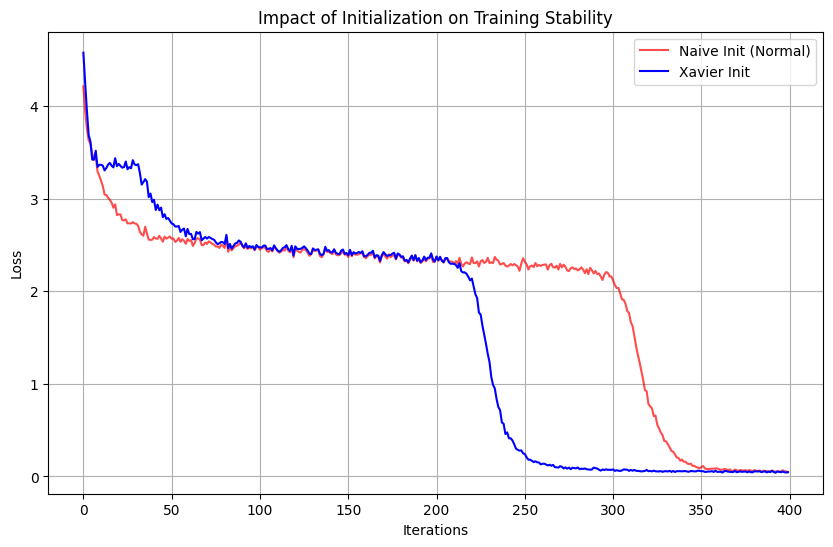

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
# We use a deeper network (6 layers) because initialization matters MORE in deep nets.
class InitConfig:
    vocab_size = 65
    n_embd = 128
    n_head = 4
    n_layer = 6          # Deeper to provoke gradient issues
    block_size = 64
    batch_size = 32
    lr = 0.001
    max_iters = 400      # Short run just to see startup behavior
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 2. THE MODEL (Standard Transformer) ---
class InitModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Embedding
        self.token_embedding = nn.Embedding(InitConfig.vocab_size, InitConfig.n_embd)
        self.pos_embedding = nn.Embedding(InitConfig.block_size, InitConfig.n_embd)
        
        # Transformer Blocks
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=InitConfig.n_embd, 
            nhead=InitConfig.n_head, 
            dim_feedforward=InitConfig.n_embd * 4,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=InitConfig.n_layer)
        
        # Output
        self.ln_f = nn.LayerNorm(InitConfig.n_embd)
        self.head = nn.Linear(InitConfig.n_embd, InitConfig.vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding(idx)
        pos_emb = self.pos_embedding(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        
        x = self.transformer(x)
        x = self.ln_f(x)
        logits = self.head(x)

        if targets is None:
            return logits, None
        
        B, T, C = logits.shape
        loss = torch.nn.functional.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

# --- 3. INITIALIZATION FUNCTIONS ---

def apply_naive_init(model):
    """
    Naive: Just random numbers N(0, 0.02) or N(0, 1).
    This often causes vanishing gradients in deep nets.
    """
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.normal_(p, mean=0.0, std=0.02) 

def apply_xavier_init(model):
    """
    Xavier (Glorot): Calculated based on layer dimensions.
    Keeps variance stable.
    """
    for name, p in model.named_parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

# --- 4. EXPERIMENT RUNNER ---
def run_training(init_type):
    print(f"--- Running {init_type} Initialization ---")
    
    # Re-initialize model freshly
    torch.manual_seed(42) # Reset seed so 'random' choices are fair
    model = InitModel().to(InitConfig.device)
    
    # Apply specific initialization
    if init_type == "Naive (Normal)":
        apply_naive_init(model)
    elif init_type == "Xavier (Glorot)":
        apply_xavier_init(model)
        
    optimizer = torch.optim.AdamW(model.parameters(), lr=InitConfig.lr)
    losses = []
    
    # Reuse get_data and get_batch from previous cell (assuming they exist)
    # If you restarted the kernel, re-run the 'get_data' function block first.
    train_data, _, _, _ = get_data() 
    
    for i in range(InitConfig.max_iters):
        xb, yb = get_batch(train_data, InitConfig.batch_size, InitConfig.block_size)
        _, loss = model(xb, yb)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Clipping (standard practice, but let's see if Xavier needs it less)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        losses.append(loss.item())
        
        if i % 100 == 0:
            print(f"Iter {i}: Loss {loss.item():.4f}")
            
    return losses

# --- 5. EXECUTE ---
loss_naive = run_training("Naive (Normal)")
loss_xavier = run_training("Xavier (Glorot)")

# --- 6. VISUALIZE ---
plt.figure(figsize=(10, 6))
plt.plot(loss_naive, label='Naive Init (Normal)', color='red', alpha=0.7)
plt.plot(loss_xavier, label='Xavier Init', color='blue')
plt.title("Impact of Initialization on Training Stability")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

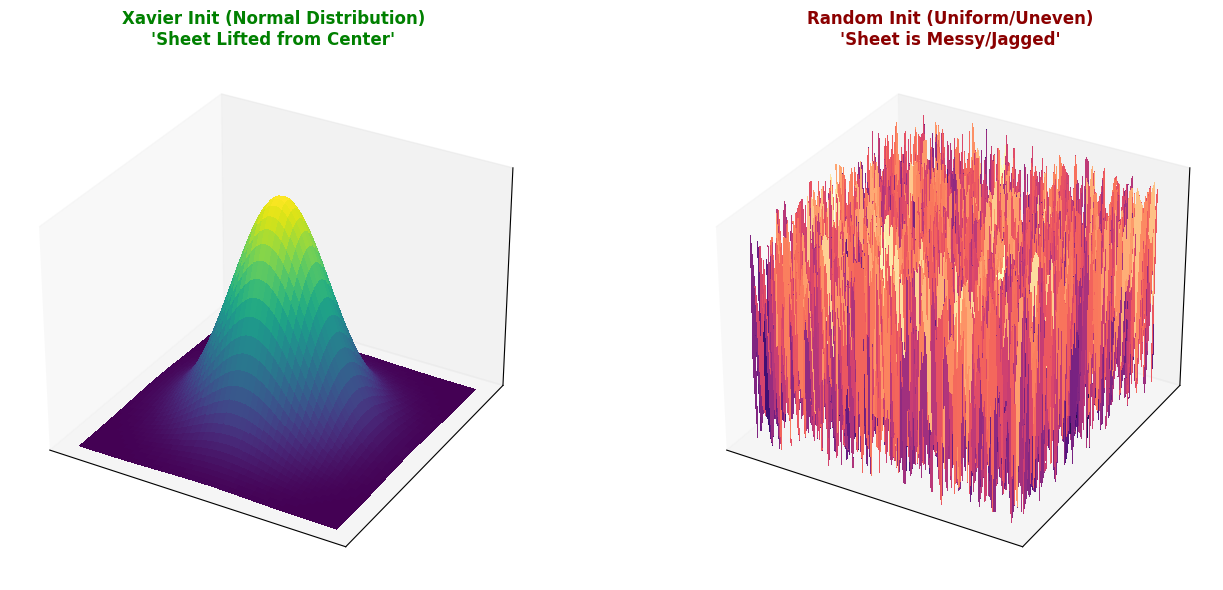

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# --- 1. SETUP THE GRID (The "Sheet") ---
# Create a coordinate grid from -3 to 3
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

# --- 2. CREATE THE SHAPES ---

# SHAPE A: XAVIER (Normal Distribution / Gaussian)
# This creates the "Lifted from Center" look (Bell Curve)
# Formula: e^(-(x^2 + y^2))
sigma = 1.0
Z_xavier = np.exp(-(X**2 + Y**2) / (2 * sigma**2))

# SHAPE B: RANDOM (Uneven / Noise)
# This creates the "Uneven/Jagged" look
# We generate random noise and smooth it slightly so it looks like a crumpled sheet
np.random.seed(42)
Z_random = np.random.uniform(0, 1, X.shape) 


# --- 3. VISUALIZATION ---
fig = plt.figure(figsize=(14, 6))

# --- PLOT 1: XAVIER (The "Lifted Sheet") ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(X, Y, Z_xavier, cmap=cm.viridis, linewidth=0, antialiased=False)
ax1.set_title("Xavier Init (Normal Distribution)\n'Sheet Lifted from Center'", fontsize=12, fontweight='bold', color='green')
ax1.set_zlim(0, 1)
# Remove axes numbers for cleaner look
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])

# --- PLOT 2: RANDOM (The "Uneven Sheet") ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X, Y, Z_random, cmap=cm.magma, linewidth=0, antialiased=False)
ax2.set_title("Random Init (Uniform/Uneven)\n'Sheet is Messy/Jagged'", fontsize=12, fontweight='bold', color='darkred')
ax2.set_zlim(0, 1)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

plt.tight_layout()
plt.show()